https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification

https://scikit-learn.org/stable/modules/lda_qda.html#dimensionality-reduction-using-linear-discriminant-analysis

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

# PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões (2022)

Tarefa 2

Autor: Pedro Henrique Galhardi Cazelatto

## Bibliotecas

Importando as bibliotecas necessárias para a execução do código.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## Dados

Importando os dados necessários para o treino e teste.

In [20]:
trainData = pd.read_csv(
    "../input/adult-pmr3508/train_data.csv",
    na_values= '?',
    index_col= ['Id'],
    header= 0,
    names= [
        "Id",
        "Age",
        "Workclass",
        "Fnlwgt",
        "Education",
        "Education-num",
        "Marital-status",
        "Occupation",
        "Relationship",
        "Race",
        "Sex",
        "Capital-gain",
        "Capital-loss",
        "Hours-per-week",
        "Native-country",
        "Target"
    ]
)

testData = pd.read_csv(
    "../input/adult-pmr3508/test_data.csv",
    na_values= '?',
    index_col= ['Id'],
    header= 0,
    names= [
        "Id",
        "Age",
        "Workclass",
        "Fnlwgt",
        "Education",
        "Education-num",
        "Marital-status",
        "Occupation",
        "Relationship",
        "Race",
        "Sex",
        "Capital-gain",
        "Capital-loss",
        "Hours-per-week",
        "Native-country"
    ]
)

## Tratamento dos Dados

Para efeitos de comparação com o kNN que fiz na primeira tarefa, usarei o mesmo tratamento de dados de lá.

Isso significa:
- Remover a coluna **Education**, e usar **Education-num**
- Preencher dados faltantes em **Workclass** com categoria *Private* e transformá-la na binária *isPrivate*;
- Apagar dados faltantes de **Occupation** e realizar One-Hot Encoding;
- Converter **Native-country** para binário *isFromUS*, preenchendo dados faltantes com 0;
- Realizar One-Hot Encoding para as colunas **Marital-status**, **Relationship** e **Race**;
- Converter **Sex** para binário *isMale*;
- Converter **Target** para binário (1 = ">50k")

In [21]:
trainData.drop("Education", axis= 1, inplace= True)

trainData["Workclass"].fillna("Private", inplace= True)
trainData.loc[trainData["Workclass"] != "Private", "Workclass"] = 0
trainData.loc[trainData["Workclass"] == "Private", "Workclass"] = 1
trainData["Workclass"] = trainData["Workclass"].astype(float)
trainData.rename(columns= {"Workclass": "isPrivate"}, inplace= True)

trainData["Occupation"].dropna(inplace= True)
trainData = pd.concat([trainData, pd.get_dummies(trainData["Occupation"], prefix= "Occ")], axis= 1)
trainData.drop("Occupation", axis= 1, inplace= True)

trainData.loc[trainData["Native-country"] != "United-States", "Native-country"] = 0
trainData.loc[trainData["Native-country"] == "United-States", "Native-country"] = 1
trainData["Native-country"] = trainData["Native-country"].astype(float)
trainData.rename(columns={"Native-country": "isFromUS"}, inplace= True)

trainData = pd.concat([trainData, pd.get_dummies(trainData["Marital-status"], prefix= "Mar")], axis= 1)
trainData.drop("Marital-status", axis= 1, inplace= True)

trainData = pd.concat([trainData, pd.get_dummies(trainData["Relationship"], prefix= "Rel")], axis= 1)
trainData.drop("Relationship", axis= 1, inplace= True)

trainData = pd.concat([trainData, pd.get_dummies(trainData["Race"], prefix= "Race")], axis= 1)
trainData.drop("Race", axis= 1, inplace= True)

trainData.loc[trainData["Sex"] != "Male", "Sex"] = 0.0
trainData.loc[trainData["Sex"] == "Male", "Sex"] = 1.0
trainData["Sex"] = trainData["Sex"].astype(float)
trainData.rename(columns={"Sex": "isMale"}, inplace= True)

trainData.loc[trainData["Target"] != ">50K", "Target"] = 0
trainData.loc[trainData["Target"] == ">50K", "Target"] = 1
trainData["Target"] = trainData["Target"].astype(float)

### Correlação entre os dados

Calculo então a correlação absoluta entre os dados e a categoria **Target**, de modo a filtrar os dados relevantes.

<AxesSubplot: >

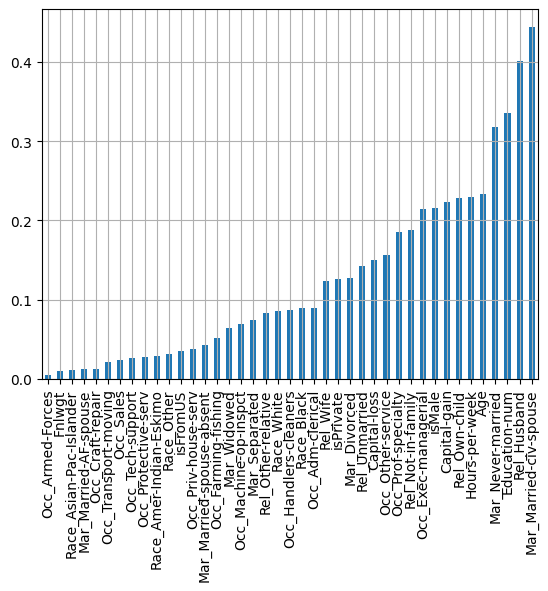

In [22]:
correlation = trainData.corr()
correlation.drop("Target", axis = 0, inplace= True)
correlation["Target"].abs().sort_values().plot(kind= "bar", grid= True)

Para a comparação desta tarefa, usarei apenas os atributos com correlação absoluta maior que 0.1.

## Definição de parâmetros

- Número de *folds* = 5
- Correlação mínima = 0.1

In [5]:
cvFolds = 5
minCorr = 0.1
scores = ("accuracy", "f1")

In [23]:
toRemove = correlation["Target"].where(correlation["Target"].abs() <= minCorr).dropna().index
trainY = trainData["Target"]
trainX = trainData.drop("Target", axis= 1)
trainX.drop(toRemove, axis= 1, inplace= True)

## Recriação do Classificador kNN

Apesar de já ter feito o classificador na tarefa passada, para efeitos da comparação recriarei o kNN usando o novo parâmetro de correlação mínima, para recalcular sua acurácia.

In [7]:
# bestScoreKNN = 0
# for k in range(1, 31):
#     knn = KNeighborsClassifier(n_neighbors= k, p= 1)
#     valScore = cross_val_score(knn, trainX, trainY, cv= cvFolds)
#     if valScore.mean() > bestScoreKNN:
#         bestScoreKNN = valScore.mean()
#         bestK = k
# print("bestK = " + str(bestK) + " and bestScore = " + str(bestScoreKNN))

O melhor K encontrado foi 25, com acurácia de 85.88%

In [8]:
knn = KNeighborsClassifier(n_neighbors= 25, p= 1)
knnScore = cross_validate(knn, trainX, trainY, cv= cvFolds, scoring= scores)
print(knnScore["test_accuracy"].mean())
print(knnScore["test_f1"].mean())

0.8587837837837838
0.6752342546328043


## 1) Regressão Logística

In [9]:
logit = LogisticRegression(penalty= "l1", solver= "liblinear", max_iter= 1000)
logitScore = cross_validate(logit, trainX, trainY, cv= cvFolds, scoring= scores)
print(logitScore["test_accuracy"].mean())
print(logitScore["test_f1"].mean())

0.8466216216216216
0.6429219948065814


## 2) LDA

In [10]:
lda = LinearDiscriminantAnalysis(solver= "eigen")
ldaScore = cross_validate(lda, trainX, trainY, cv= cvFolds, scoring= scores)
print(ldaScore["test_accuracy"].mean())
print(ldaScore["test_f1"].mean())

0.8351965601965603
0.6137010654158616


## 3) Random Forests

Para uma floresta aleatória, é necessário definir a quantidade de árvores e o tamanho máximo delas.

Primeiro estimo o tamanho máximo usando uma floresta bem grande, de modo que provavelmente todas as *features* serão utilizadas, e me darão uma boa estimativa da profundidade ideal.

Depois, procuro o melhor número de árvores da floresta com a profundidade escolhida.

In [11]:
bestScoreRF = 0
for depth in range(3, 20, 2):
    rndForest = RandomForestClassifier(n_estimators= 300, max_depth= depth)
    rndForestScore = cross_val_score(rndForest, trainX, trainY, cv= cvFolds)
    if rndForestScore.mean() > bestScoreRF:
        bestScoreRF = rndForestScore.mean()
        bestDepth = depth
print("\nbestD = " + str(bestDepth) + " and bestScore = " + str(bestScoreRF))


bestD = 13 and bestScore = 0.8625307125307125


In [12]:
bestScoreRF = 0
for nTree in range(10, 101):
    rndForest = RandomForestClassifier(n_estimators= nTree, max_depth= bestDepth)
    rndForestScore = cross_val_score(rndForest, trainX, trainY, cv= cvFolds)
    if rndForestScore.mean() > bestScoreRF:
        bestScoreRF = rndForestScore.mean()
        bestNTree = nTree
print("\nbestN = " + str(bestNTree) + " and bestScore = " + str(bestScoreRF))


bestN = 62 and bestScore = 0.8627149877149878


In [13]:
rndForest = RandomForestClassifier(n_estimators= bestNTree, max_depth= bestDepth)
rndForestScore = cross_validate(rndForest, trainX, trainY, cv= cvFolds, scoring= scores)
print(rndForestScore["test_accuracy"].mean())
print(rndForestScore["test_f1"].mean())

0.8618550368550368
0.6706722463066004


## 4) Rede Neural

Para a rede neural, defini usar apenas uma camada escondida, pois é mais rápido de treinar e possui acurácia suficiente. Com validação cruzada escolho a melhor quantidade de *perceptrons* da camada.

In [14]:
bestScoreMLP = 0
for neurons in range(5, 50):
    mlp = MLPClassifier(hidden_layer_sizes= (neurons))
    mlpScore = cross_val_score(mlp, trainX, trainY, cv= cvFolds)
    if mlpScore.mean() > bestScoreMLP:
        bestScoreMLP = mlpScore.mean()
        bestNeurons = neurons
print("\nbestN = " + str(bestNeurons) + " and bestScore = " + str(bestScoreMLP))


bestN = 29 and bestScore = 0.8444103194103194


In [15]:
mlp = MLPClassifier(hidden_layer_sizes= (bestNeurons))
mlpScore = cross_validate(mlp, trainX, trainY, cv= cvFolds, scoring= scores)
print(mlpScore["test_accuracy"].mean())
print(mlpScore["test_f1"].mean())

0.8361486486486486
0.6170321016948669


# Comparando os Classificadores

Na execução em minha máquina, encontrei os seguintes valores de acurácia e F1:

| Classificador | Acurácia | F1-score |
| --- | --- | --- |
| 0) kNN | 85.88% | 67.52% |
| 1) Reg Logística | 84.66% | 64.30% |
| 2) LDA | 83.52% | 61.37% |
| 3) Rnd Forest | 86.19% | 67.07% |
| 4) Rede Neural | 83.88 | 59.20% |

Com tais valores, posso considerar a floresta aleatória como melhor entre os novos classificadores. Em comparação com o kNN, sua acurácia foi um pouco melhor, mas teve o valor F1 reduzido. 

# Classificador Final

Para o classificador final de teste, usarei a floresta aleatória com os parâmetros encontrados.

Primeiro, é necessário preparar os dados de teste como fiz com os de treino.

In [24]:
testData.drop("Education", axis= 1, inplace= True)

testData["Workclass"].fillna("Private", inplace= True)
testData.loc[testData["Workclass"] != "Private", "Workclass"] = 0
testData.loc[testData["Workclass"] == "Private", "Workclass"] = 1
testData["Workclass"] = testData["Workclass"].astype(float)
testData.rename(columns= {"Workclass": "isPrivate"}, inplace= True)

testData["Occupation"].dropna(inplace= True)
testData = pd.concat([testData, pd.get_dummies(testData["Occupation"], prefix= "Occ")], axis= 1)
testData.drop("Occupation", axis= 1, inplace= True)

testData.loc[testData["Native-country"] != "United-States", "Native-country"] = 0
testData.loc[testData["Native-country"] == "United-States", "Native-country"] = 1
testData["Native-country"] = testData["Native-country"].astype(float)
testData.rename(columns= {"Native-country": "isFromUS"}, inplace= True)

testData = pd.concat([testData, pd.get_dummies(testData["Marital-status"], prefix= "Mar")], axis= 1)
testData.drop("Marital-status", axis= 1, inplace= True)

testData = pd.concat([testData, pd.get_dummies(testData["Relationship"], prefix= "Rel")], axis= 1)
testData.drop("Relationship", axis= 1, inplace= True)

testData = pd.concat([testData, pd.get_dummies(testData["Race"], prefix= "Race")], axis= 1)
testData.drop("Race", axis= 1, inplace= True)

testData.loc[testData["Sex"] != "Male", "Sex"] = 0
testData.loc[testData["Sex"] == "Male", "Sex"] = 1
testData["Sex"] = testData["Sex"].astype(float)
testData.rename(columns= {"Sex": "isMale"}, inplace= True)

testData.drop(toRemove, axis= 1, inplace= True)

Agora, basta montar o classificador.

In [25]:
classFinal = RandomForestClassifier(n_estimators= bestNTree, max_depth= bestDepth)
classFinal.fit(trainX, trainY)

RandomForestClassifier(max_depth=13, n_estimators=62)

In [26]:
guess = classFinal.predict(testData)
submission = pd.DataFrame()
submission[0] = testData.index
submission[1] = guess
submission.columns = ["Id", "income"]
submission.loc[submission["income"] == 0, "income"] = "<=50K"
submission.loc[submission["income"] == 1, "income"] = ">50K"
submission.to_csv("submission.csv", index= False)